In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class Linear:
    """
    This class implements a liner (or dense) layer. It has a call function to compute the forward step, and a backward function to calculate the gradients and apply them on the weights.
    """
    def __init__(self, input_size, output_size):
        # He Weights Initialization
        std = np.sqrt(2.0 / input_size)
        self.weights = np.random.randn(input_size, output_size) * std

        # small values to avoid zero neurons using ReLU activation function
        self.bias = np.random.uniform(-0.05, 0.05, output_size)

    def __call__(self, input_data):
        # calculates the output of the layer

        output = np.dot(input_data, self.weights) + self.bias

        self.last_couple = (input_data, output)

        return output

    def backward(self, input, output_error, learning_rate):
        # calculates the gradients associated to the layer and returns the gradient to back propagate

        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error.sum(0)

        return input_error

In [3]:
class tanh:
    """
    This class implements the Tanh activation function. It has a call function to compute the forward step, and a backward function to calculate the gradients using the derivative of the tanh function (tanh prime).
    """
    def __call__(self, x):
        return np.tanh(x)

    def backward(self, x, output_error, *args, **kwargs):
        return (1-np.tanh(x)**2) * output_error

In [4]:
class CrossEntropy:
    """
    This class implements the Cross entropy error function. It is used mainly for classification problems. It implements a forward step and a backward one, which calculates the derivative of the error. It also implements the softmax function that, given a prediction, calculates the probabilities associated to each class.
    """

    def softmax(self, y):
        tmp = np.exp(y)
        output = tmp / np.sum(tmp, -1, keepdims=True)
        return output

    def __call__(self, y_true, y_pred, **kwargs):
        probs = self.softmax(y_pred)
        p = probs[np.arange(len(probs)), y_true]
        p = np.log(p)
        return np.mean(p)

    def backward(self, y_true, y_pred):
        probs = self.softmax(y_pred)
        b = np.zeros((probs.shape[0], probs.shape[1]))
        b[np.arange(probs.shape[0]), y_true] = 1
        probs = probs - b

        return probs

In [5]:
def batcher(x, y, batch_size):
    """
    This function is used to shuffle the dataset and return the batches, in a generative way (a batch is calculated each time the function is called, and not all at the same time).
    """
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    for i in range(0, len(x), batch_size):
        _i = idx[i:i + batch_size]
        _x, _y = x[_i], y[_i]
        yield _x, _y

def forward(x, model):
    """
    This function implement the forward step. Given a model as a list of layers, it propagates the input through the whole model, to produce the output
    """
    inputs = []
    for layer in model:
        inputs.append(x)
        x = layer(x)
    return x, inputs

def calculate_accuracy(y_true, y_pred):
    """
    This function calculates the accuracy score. Used only for classification problems
    """

    y_pred = y_pred.argmax(-1)
    a = y_true == y_pred
    a = a.sum() / len(y_true)
    return a

def training(x, y, model, loss, epochs, learning_rate, batch_size=4, print_errors=False):
    """
    This function implement the whole training process. It is possible to pass the loss class, the number of epochs and the learning rate used to modify the parameters of the model. Also, it is possible to choose the bartch size and if the mean error must be printed after each epoch, or not.
    """

    errors = []
    for i in range(epochs):
        epoch_errors = []
        for _x, _y in batcher(x, y, batch_size):

            o, inputs = forward(_x, model)

            error = loss(_y, o)
            epoch_errors.append(error)

            error_gradient = loss.backward(_y, o)
            for o, layer in reversed(list(zip(inputs, model))):
                error_gradient = layer.backward(o, error_gradient, learning_rate)

        errors.append(epoch_errors)

        if print_errors:
            print(f'Error after epoch {i}: {np.mean(epoch_errors)}')

    return errors

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

x, y = load_digits(return_X_y=True)

# we standardize the values in the range [0, 1]
x = x / 16
# then we convert it into discrete pixels
x = np.where(x > 0.5, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
# create and train the model

model = [Linear(64, 32), tanh(), Linear(32, 20), tanh(), Linear(20, 10)]
loss = CrossEntropy()

errors = training(X_train, y_train, model, loss, epochs=20, learning_rate=0.01)
print('Train score', calculate_accuracy(y_train, forward(X_train, model)[0]))
print('Test score', calculate_accuracy(y_test, forward(X_test, model)[0]))

Train score 0.9979123173277662
Test score 0.9111111111111111


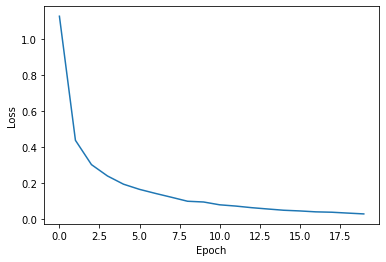

In [8]:
plt.plot(np.arange(20), [-np.mean(e) for e in errors])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
from copy import deepcopy
from collections import defaultdict


def modify_digits(images, labels, images_per_label=3, pixels_to_swap=2):
    res = defaultdict(list)
    original_images = defaultdict(list)
    y = []

    for img, l in zip(images, labels):
        if len(res[l]) < images_per_label:

            new_img = deepcopy(img)
            original_images[l].append(img)
            y.append(l)

            zeros = (new_img <= 0.5).nonzero()[0]
            ones = (new_img > 0.5).nonzero()[0]

            np.random.shuffle(zeros)
            np.random.shuffle(ones)

            for i in range(pixels_to_swap):
                c = new_img[zeros[i]]
                new_img[zeros[i]] = new_img[ones[i]]
                new_img[ones[i]] = c

            res[l].append(new_img)

    original_images = np.asarray([[v1 for v1 in v]  for v in original_images.values()]).reshape(-1, 64)
    modified_images = np.asarray([[v1 for v1 in v]  for v in res.values()]).reshape(-1, 64)
    y = np.asarray([[k] * len(v)   for k, v in res.items()]).reshape(-1)

    return original_images, modified_images, y

In [10]:
original, modified, labels = modify_digits(X_test, y_test, pixels_to_swap=10)

<Figure size 432x288 with 0 Axes>

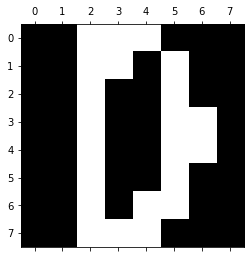

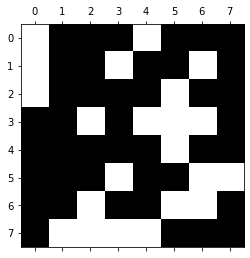

0


In [11]:

plt.gray()
plt.matshow(original[0].reshape(8, 8))
plt.show()
plt.matshow(modified[0].reshape(8, 8))
plt.show()
print(labels[0])

In [12]:
results = []

for i in range(0, 10):
    original, modified, labels = modify_digits(X_test, y_test, pixels_to_swap=i)
    results.append(calculate_accuracy(labels, forward(modified, model)[0]))
    print(f'Experiment swapping {i} pixels')
    print('Original images score', calculate_accuracy(labels, forward(original, model)[0]))
    print('Swapped pixels images score', calculate_accuracy(labels, forward(modified, model)[0]))

Experiment swapping 0 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.9333333333333333
Experiment swapping 1 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.8
Experiment swapping 2 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.7666666666666667
Experiment swapping 3 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.7333333333333333
Experiment swapping 4 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.6666666666666666
Experiment swapping 5 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.7333333333333333
Experiment swapping 6 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.5333333333333333
Experiment swapping 7 pixels
Original images score 0.9333333333333333
Swapped pixels images score 0.3333333333333333
Experiment swapping 8 pixels
Original images score 0.9333333333333333
Swapped p

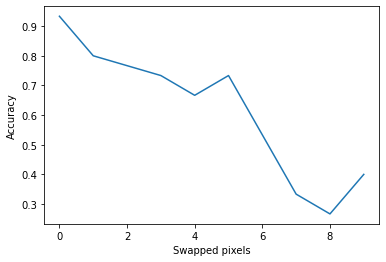

In [13]:
plt.plot(np.arange(10), results)
plt.xlabel('Swapped pixels')
plt.ylabel('Accuracy')
plt.show()